In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Load MOSES SMILES file
# df = pd.read_csv("../moses/data/train.smi", names=["smiles"])

In [5]:
df_drugsmiles = pd.read_csv("/Users/chusanarompo/DEV/MASTER/TargetGAN_play/data/CPI/smiles.smi", names=["smiles"])
print(df_drugsmiles.head())
print(df_drugsmiles.shape)

                                              smiles
0  [CH2]C1CC(n2ccc3c(-c4cc5cc(OC)ccc5[nH]4)ncnc32...
1  [CH2]C1CC(n2ccc3c(-c4cc5ccc(C)cc5[nH]4)ncnc32)...
2  [CH2]C1CC(n2ccc3c(-c4cc5ccccc5[nH]4)nc(C)nc32)...
3  NS(=O)(=O)OCC1CC(n2ccc3c(-c4cc5ccccc5[nH]4)ncn...
4  [CH2]C1CC(n2ccc3c(-c4cc5ccc(Cl)cc5[nH]4)ncnc32...
(551223, 1)


In [14]:
df_protein = pd.read_csv("/Users/chusanarompo/DEV/MASTER/TargetGAN_play/data/CPI/uniprot_ID.smi", names=["smiles"])
print(df_protein.head())
print(df_protein.shape)

   smiles
0  A0AVT1
1  A0AVT1
2  A0AVT1
3  A0AVT1
4  A0AVT1
(551223, 1)


In [ ]:
df_testmerge = pd.merge(df_drugsmiles,df_protein, left_index=True, right_index=True)
df_testmerge

,smiles_x,smiles_y
0,[CH2]C1CC(n2ccc3c(-c4cc5cc(OC)ccc5[nH]4)ncnc32...,A0AVT1
1,[CH2]C1CC(n2ccc3c(-c4cc5ccc(C)cc5[nH]4)ncnc32)...,A0AVT1
2,[CH2]C1CC(n2ccc3c(-c4cc5ccccc5[nH]4)nc(C)nc32)...,A0AVT1
3,NS(=O)(=O)OCC1CC(n2ccc3c(-c4cc5ccccc5[nH]4)ncn...,A0AVT1
4,[CH2]C1CC(n2ccc3c(-c4cc5ccc(Cl)cc5[nH]4)ncnc32...,A0AVT1
...,...,...
551218,N=C(N)Nc1ccc(CC(NC(=O)OCc2ccccc2)P(=O)(Oc2cccc...,Q9Y5K2
551219,N=C(N)NCCCC(NC(=O)OCc1ccccc1)P(=O)(Oc1ccccc1)O...,Q9Y5K2
551220,N=C(N)c1ccc(CCC(NC(=O)OCc2ccccc2)P(=O)(Oc2cccc...,Q9Y5K2
551221,N=C(N)Nc1ccc(C(NC(=O)OCc2ccccc2)P(=O)(Oc2ccccc...,Q9Y5K2


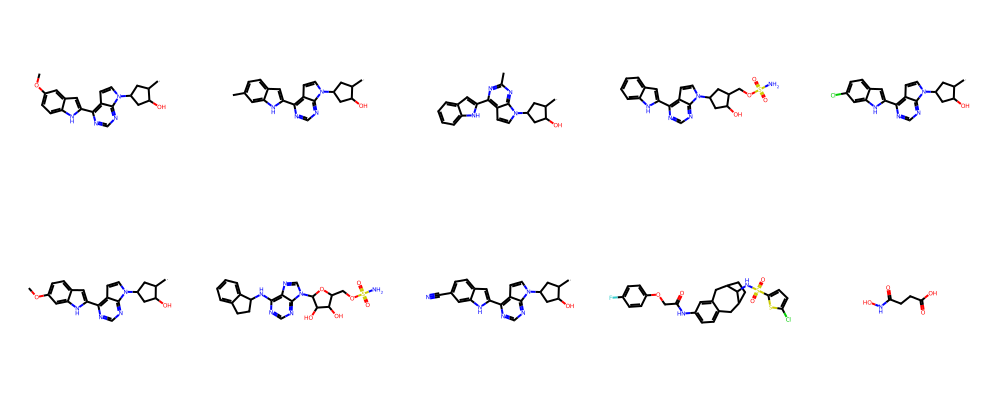

In [ ]:
# Convert first few to molecules
mols = [Chem.MolFromSmiles(s) for s in df_drugsmiles["smiles"].head(10)]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
img
# img.save("sample_mols.png")

## Init TAPE: Protein Embeddings
#### AMINO ACID SEQUENCES -> IUPAC NAME

In [ ]:
import torch
from tape import ProteinBertModel, TAPETokenizer

model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model


100%|██████████| 370264230/370264230 [02:58<00:00, 2076984.78B/s]


#### EMBEDDED AMINO SEQ -> tokenize with TAPETokenizer iupac

In [11]:

# Pfam Family: Hexapep, Clan: CL0536
sequence = 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ'
token_ids = torch.tensor([tokenizer.encode(sequence)])
output = model(token_ids)
sequence_output = output[0]
pooled_output = output[1]

# NOTE: pooled_output is *not* trained for the transformer, do not use
# w/o fine-tuning. A better option for now is to simply take a mean of
# the sequence output

In [15]:
token_ids

tensor([[ 2, 11,  7, 23, 25,  9,  8, 21,  7, 15, 13, 11, 16, 11,  5, 13, 15, 15,
         17, 11,  7, 25, 13, 11, 22, 11, 22, 15, 25,  5,  5, 11,  5, 15, 13, 23,
         20,  3]])

In [18]:
model

ProteinBertModel(
  (embeddings): ProteinBertEmbeddings(
    (word_embeddings): Embedding(30, 768, padding_idx=0)
    (position_embeddings): Embedding(8192, 768)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ProteinBertEncoder(
    (layer): ModuleList(
      (0-11): 12 x ProteinBertLayer(
        (attention): ProteinBertAttention(
          (self): ProteinBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ProteinBertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermed